Classificatore KNN in SKlearn
L'implementazione del classificatore KNN in SKlearn può essere eseguita facilmente con l'aiuto del modulo KNeighborsClassifier(). In questo esempio, useremo un set di dati di giocatori per classificare come ala, guardia, play, centro in base alle statistiche e all'altezza con il classificatore KNN in Sklearn.

 Importazione delle librerie necessarie

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Importo il set di dati dei giocatori

In [90]:
giocatori = pd.read_csv('giocatori.csv')

Controlla quanti record ci sono per le etichette di classe Play, Guardia, Ala, Centro. Possiamo vedere che è un set di dati abbastanza equilibrato.

In [91]:
giocatori.info()
giocatori['ruolo'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nome_giocatore    247 non-null    object 
 1   numero_giocatore  233 non-null    float64
 2   squadra           247 non-null    object 
 3   ruolo             209 non-null    object 
 4   altezza           247 non-null    int64  
 5   minuti            247 non-null    float64
 6   FALLI_C           247 non-null    float64
 7   FALLI_S           247 non-null    float64
 8   T2_R              247 non-null    float64
 9   T2_T              247 non-null    float64
 10  T2_PER            247 non-null    float64
 11  T3_R              247 non-null    float64
 12  T3_T              247 non-null    float64
 13  T3_PER            247 non-null    float64
 14  T1_R              247 non-null    float64
 15  T1_T              247 non-null    float64
 16  T1_PER            247 non-null    float64
 1

Ala        69
Guardia    54
Play       48
Centro     38
Name: ruolo, dtype: int64

Droppo le colonne che sicuramente non influiranno sulla predizione del ruolo, ma mantengo i minuti per utilizzarli come fattore di normalizzazione sulle altre colonne

In [92]:
giocatori = giocatori.drop('nome_giocatore', axis = 1)
giocatori = giocatori.drop('numero_giocatore', axis = 1)
giocatori = giocatori.drop('squadra', axis = 1)
giocatori = giocatori.drop('RIM_D', axis = 1)
giocatori = giocatori.drop('RIM_O', axis = 1)
giocatori = giocatori.dropna();

import numpy as np

# Definire una funzione per scalare i valori di ogni riga
def scale_row(row, scale_col):
    numeric_cols = row.select_dtypes(include=[np.number]).drop(scale_col, axis=0).index
    scale_factor = row[scale_col]/40
    row = row * float(scale_factor)
    return row

# Scalare i valori di ogni riga per il valore nella colonna2
giocatori = giocatori.apply(lambda x: scale_row(x, 'minuti'), axis=1)

print(giocatori)

rimuovo i restanti campi inutili

In [93]:
giocatori = giocatori.drop('minuti', axis = 1)
giocatori = giocatori.drop('T1_PER', axis = 1)
giocatori = giocatori.drop('T2_PER', axis = 1)
giocatori = giocatori.drop('T3_PER', axis = 1)

Analisi esplorativa dei dati
Dopo aver caricato il set di dati, eseguiremo alcune analisi esplorative dei dati per comprendere meglio i nostri dati.

Per prima cosa visualizziamo la correlazione tra le diverse caratteristiche presenti nel nostro set di dati. Quindi, useremo un grafico a linee per comprendere le caratteristiche fortemente (positivamente) correlate, seguite da funzionalità correlate settimanali e, infine, esamineremo le caratteristiche correlate negativamente.

C:\Users\nicol\AppData\Local\Temp\ipykernel_22596\730944499.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  player_correlation = giocatori.corr()


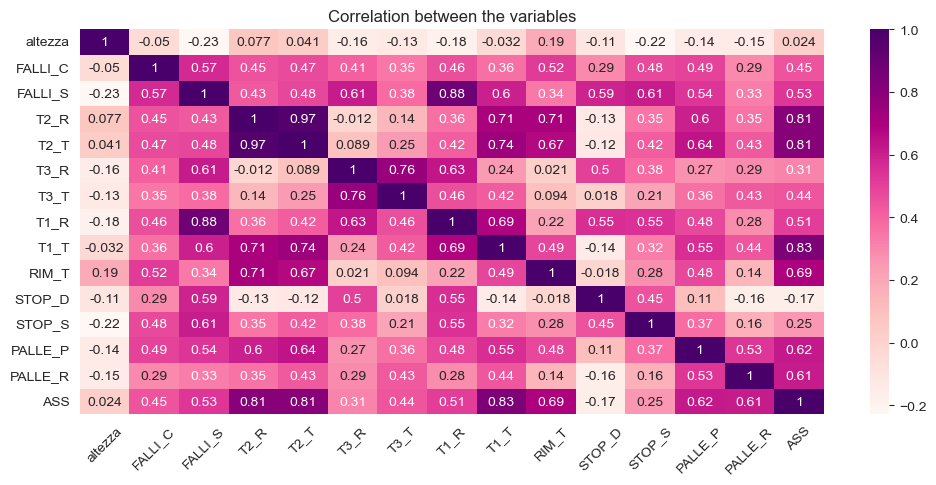

In [94]:
#Analisi esplorativa dei dati
#correlation matrix and the heatmap
plt.subplots(figsize=(12,5))
player_correlation = giocatori.corr()
sns.heatmap(player_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot: xlabel='ruolo', ylabel='altezza'>

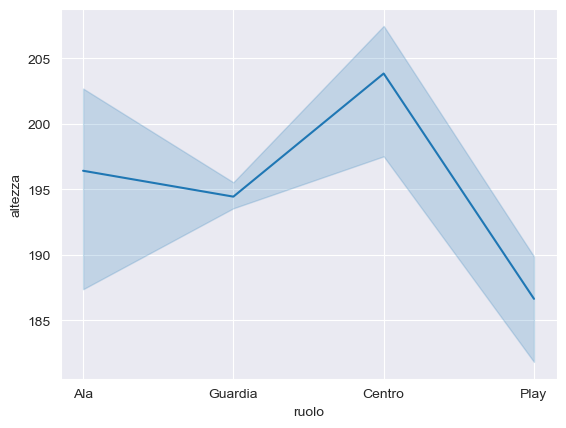

In [95]:
sns.lineplot(data=giocatori, x="ruolo", y="altezza")

Dal seguente grafico è possibili evincere che il ruolo dei giocatori è molto legato al ruolo dei giocatori

Suddivisione del set di dati in set di formazione e test
Abbiamo diviso i set di formazione e test con l'aiuto della funzione train_test_split()

In [96]:
x = giocatori.drop('ruolo', axis=1)
y = giocatori['ruolo']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=100)

Adattamento del modello con K-cross Validation e GridSearchCV
Per prima cosa creiamo un'istanza del classificatore KNN e quindi prepariamo un intervallo di valori dell'iperparametro K da 1 a 31 che verrà utilizzato da GridSearchCV per trovare il valore migliore di K.

Inoltre, impostiamo le dimensioni dei nostri lotti di convalida incrociata cv = 10 e impostiamo le metriche di punteggio con precisione come preferenza.



In [102]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)
print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 7}
Accuracy for our training dataset with tuning is : 64.23%


Verifica dell'accuratezza dei dati di prova
Poiché ora abbiamo il miglior iperparametro di K = 7, questo può essere utilizzato per adattare un modello KNN e verificarne l'accuratezza sul set di dati di test non visto.

In [104]:
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(x, y)

y_test_hat=knn.predict(x_test)

test_accuracy=accuracy_score(y_test,y_test_hat)*100

print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 76.19%


Ora valutiamo il modello utilizzando i dati di test, a questo scopo abbiamo impostato una matrice di confusione per aiutarci a scoprire veri positivi, veri negativi, falsi positivi e falsi negativi.

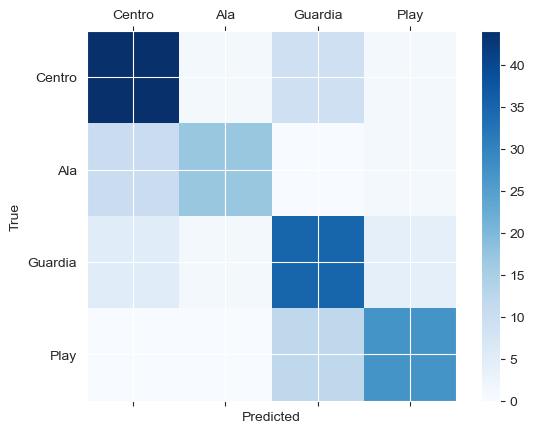

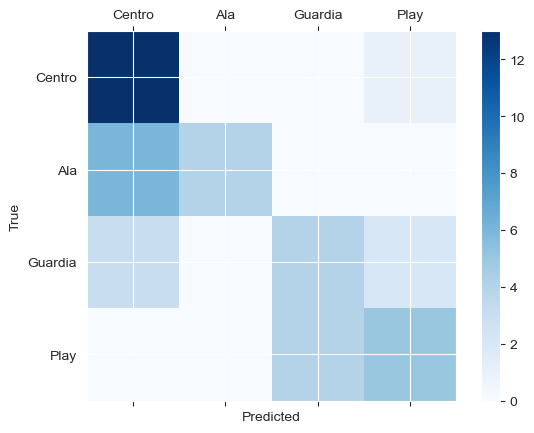

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(grid, X_train, y_train, values_format='d'):
    cm = confusion_matrix(y_train, grid.predict(X_train))
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(range(len(set(y_train))))
    ax.set_yticks(range(len(set(y_train))))
    ax.set_xticklabels(list(set(y_train)))
    ax.set_yticklabels(list(set(y_train)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(grid, x_train, y_train, values_format='d')
plot_confusion_matrix(grid, x_test, y_test, values_format='d')